# Efficacy of Vocational Rehabilitation Services in Texas 

> Dataset: [Current Population Survey, July 2021: Disability Supplement](https://api.census.gov/data/2021/cps/disability/jul.html)
* The universe consists of all persons in the civilian non-institutional population of the United States living in households. 
* The probability sample selected to represent the universe consists of approximately 50,000 households.

### Imports

In [3]:
import requests
import pandas as pd
import numpy as np

### Data Dictionary
> Include information such as exact variable name in API, variable name in analysis, and variable name in visualization, description, measurement units, expected values, expected min/max


### Query Texas Records
> Querying individual records for **every** county in Texas

In [ ]:
HOST = "https://api.census.gov/data"
year = "2019"
dataset = "cps/disability/jul"
base_url = "/".join([HOST, year, dataset])

predicates = {}
get_vars = ["PEMLR",
            "PESD1", 
            "PESD6A", 
            "PESD6B", 
            "PESD6C", 
            "PESD6D", 
            "PESD6E", 
            "PESD6F", 
            "PESD6G", 
            "PESD7A", 
            "PESD7B", 
            "PESD7C",
            "PESD7E", 
            "PESD7G", 
            "PRDISFLG", 
            "PESD41", 
            "PESD42", 
            "PESD43", 
            "PESD44", 
            "PESD45", 
            "PESD46", 
            "PESD47",
            "PESD48", 
            "PESD49",
            "PTDTRACE",
            "PESEX",
            "PRTAGE",
            "HEFAMINC"
            ]
predicates["get"] = ",".join(get_vars)
predicates["for"] = "county:*"
predicates["in"] = "state:48"

r = requests.get(base_url, params=predicates)

### Format Data Frame and turn to CSV

In [70]:
col_names = [
    "labor_force_employment_status",
    "how_disability_affects_ability_to_work",
    "used_vocational_rehabilitation_agencies",
    "used_one_stop_career_centers",
    "used_the_ticket_to_work_program",
    "used_assistive_technology_act_prog",
    "used_ctr_for_indpt_living_for_ind_w_dis",
    "used_the_client_assistance_program",
    "used_any_other_employment_assistance_program",
    "how_helpful_vocational_rehab_agency",
    "how_helpful_one_stop_career_centers",
    "the_ticket_to_work_program_helpfulness",
    "ctr_for_indpdt_living_for_ind_w_dis_helpful",
    "other_employment_assist_program_helpful",
    "does_this_person_have_any_of_these_disability_conditions",
    "barrier_lack_of_education_or_training",
    "barrier_lack_of_job_counseling",
    "barrier_lack_of_transportation",
    "barrier_loss_of_government_assistance",
    "barrier_need_for_special_features",
    "barrier_employer_or_coworker_attitudes",
    "barrier_your_difficulty_with_disability",
    "barrier_other",
    "barrier_none",
    "demographics_race_of_respondent",
    "demographics_sex",
    "demographics_age",
    "household_total_family_income_past_12_months",
    "state",
    "county"
]
df = pd.DataFrame(columns=col_names, data=r.json()[1:])
df.to_csv("raw-data.csv")

### Clean Data and Correct Output

In [71]:
data = pd.read_csv('raw-data.csv',header=0)
# drop all records that are not in the universe of labor_force_employment_status
filteredData = data[data["labor_force_employment_status"] != -1]
filteredData = filteredData.loc[:,  ~filteredData.columns.str.contains('^Unnamed')]

print(len(filteredData))
# drop all records that do not have a dissability
filteredData = filteredData[filteredData["does_this_person_have_any_of_these_disability_conditions"] == 1]
print(len(filteredData))

# categorize output variable into binary options
filteredData["labor_force_employment_status"] = filteredData["labor_force_employment_status"].apply(lambda x: 1 if x == 1 or x == 2 else 0)

filteredData.to_csv("cleaned-data.csv")

5338
593


### Find significant variables
> Note: Solving a classification problem via inference

#### Options:
- Logistic Regression - commonly used for classification problems
- Stepwise
- Decision Trees
- Random forrest
- Neural Network

### Logistic Regression
* [Documentation](https://pytorch.org/tutorials/beginner/nn_tutorial.html#neural-net-from-scratch-no-torch-nn)
* Train minimal neural network (logsitic regression, since there are no hidden layers)

#### Step 1: Turn df to tensors

In [ ]:
import numpy as np
import torch
from sklearn.model_selection import train_test_split

data = pd.read_csv('cleaned-data.csv',header=0)
data = data.loc[:,  ~data.columns.str.contains('^Unnamed')]

# 80% training, 20% validation
x_var = data.loc[:, data.columns != "labor_force_employment_status"]
y_var = data.loc[:, data.columns == "labor_force_employment_status"]

x_train, x_valid, y_train, y_valid = train_test_split(
    x_var,
    y_var,
    test_size=0.2,
    random_state=42
)

# Convert DataFrames to NumPy arrays and then to tensors
x_train = torch.tensor(x_train.values, dtype=torch.float32)
x_valid = torch.tensor(x_valid.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)
y_valid = torch.tensor(y_valid.values, dtype=torch.float32)
n, c = x_train.shape

NameError: name '_C' is not defined

#### Step 2: Create model

In [ ]:
import math

weights = torch.randn(c, 2) / math.sqrt(c)
weights.requires_grad_()

bias = torch.zeros(2, requires_grad=True)

def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)

bs = 64  # batch size

xb = x_train[0:bs]  # a mini-batch from x
preds = model(xb)  # predictions

def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

y_train = y_train.squeeze().long()  # Ensure it's 1D and long type for classification
yb = y_train[0:bs]

def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

print(accuracy(preds, yb))

lr = 0.5  # learning rate
epochs = 2  # how many epochs to train for

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

print(loss_func(model(xb), yb), accuracy(model(xb), yb))


tensor(0.4531)
tensor(nan, grad_fn=<NegBackward0>) tensor(0.2759)


#### Scikit logistic regression

Index(['how_disability_affects_ability_to_work',
       'used_vocational_rehabilitation_agencies',
       'used_one_stop_career_centers', 'used_the_ticket_to_work_program',
       'used_assistive_technology_act_prog',
       'used_ctr_for_indpt_living_for_ind_w_dis',
       'used_the_client_assistance_program',
       'used_any_other_employment_assistance_program',
       'how_helpful_vocational_rehab_agency',
       'how_helpful_one_stop_career_centers',
       'the_ticket_to_work_program_helpfulness',
       'ctr_for_indpdt_living_for_ind_w_dis_helpful',
       'other_employment_assist_program_helpful',
       'does_this_person_have_any_of_these_disability_conditions',
       'barrier_lack_of_education_or_training',
       'barrier_lack_of_job_counseling', 'barrier_lack_of_transportation',
       'barrier_loss_of_government_assistance',
       'barrier_need_for_special_features',
       'barrier_employer_or_coworker_attitudes',
       'barrier_your_difficulty_with_disability', 'barri

c:\anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
c:\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


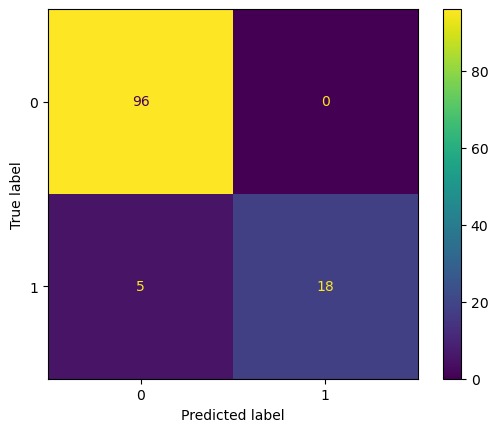

In [ ]:
# Scikit logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


data = pd.read_csv('cleaned-data.csv',header=0)
data = data.loc[:,  ~data.columns.str.contains('^Unnamed')]

# 80% training, 20% validation
x_var = data.loc[:, data.columns != "labor_force_employment_status"]
y_var = data.loc[:, data.columns == "labor_force_employment_status"]

X_train, X_test, y_train, y_test = train_test_split(
    x_var,
    y_var,
    test_size=0.2,
    random_state=42
)

clf_log = LogisticRegression()
clf_log = clf_log.fit(X_train, y_train)

y_pred = clf_log.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=clf_log.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_log.classes_)
disp.plot()
print(classification_report(y_test, y_pred))
 

### Decision Tree
> re-use training and test datasets

[https://www.datacamp.com/tutorial/decision-tree-classification-python](Resource)

[https://scikit-learn.org/stable/modules/tree.html](Docs on decision trees)

[https://www.youtube.com/watch?v=q90UDEgYqeI](Video)

[https://scikit-learn.org/1.5/auto_examples/tree/plot_cost_complexity_pruning.html](Docs on Pruning)

#### Preliminary Tree
* no pruning done with default hyperparameters

[Text(0.8315217391304348, 0.9705882352941176, 'how_disability_affects_ability_to_work <= 0.0\ngini = 0.294\nsamples = 474\nvalue = [389, 85]\nclass = Unemployed'),
 Text(0.7880434782608695, 0.9117647058823529, 'barrier_your_difficulty_with_disability <= 0.0\ngini = 0.08\nsamples = 406\nvalue = [389, 17]\nclass = Unemployed'),
 Text(0.7445652173913043, 0.8529411764705882, 'demographics_age <= 68.5\ngini = 0.261\nsamples = 110\nvalue = [93, 17]\nclass = Unemployed'),
 Text(0.6141304347826086, 0.7941176470588235, 'barrier_lack_of_education_or_training <= -1.5\ngini = 0.367\nsamples = 66\nvalue = [50, 16]\nclass = Unemployed'),
 Text(0.5706521739130435, 0.7352941176470589, 'gini = 0.0\nsamples = 8\nvalue = [8, 0]\nclass = Unemployed'),
 Text(0.657608695652174, 0.7352941176470589, 'household_total_family_income_past_12_months <= 4.5\ngini = 0.4\nsamples = 58\nvalue = [42, 16]\nclass = Unemployed'),
 Text(0.6141304347826086, 0.6764705882352942, 'gini = 0.0\nsamples = 7\nvalue = [7, 0]\nclass

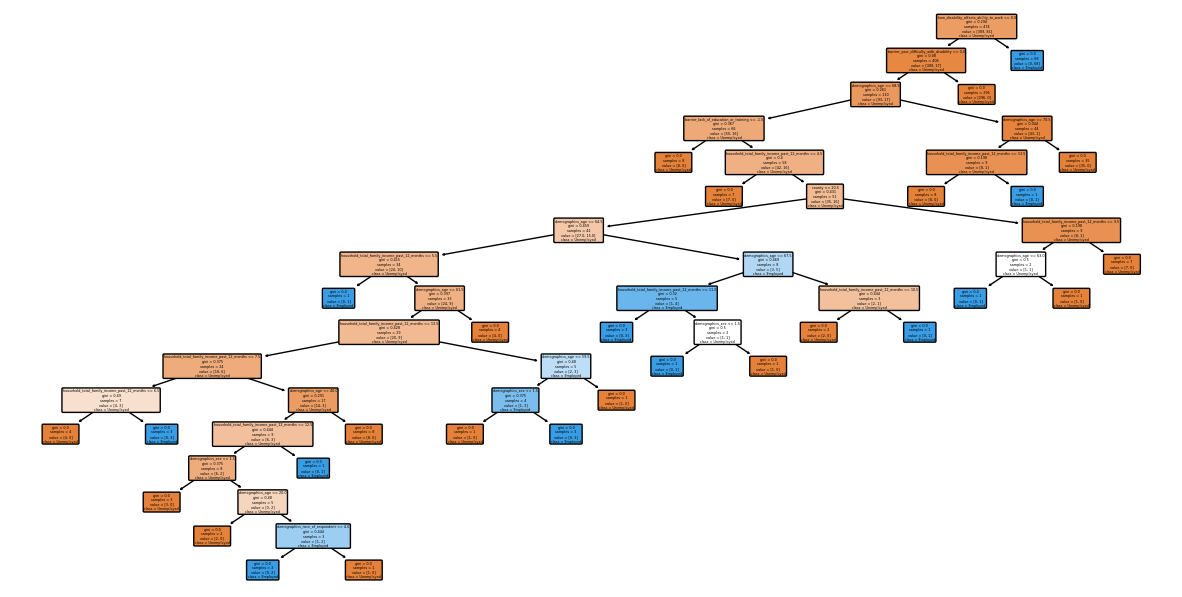

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import matplotlib.pyplot as plt

data = pd.read_csv('cleaned-data.csv',header=0)
data = data.loc[:,  ~data.columns.str.contains('^Unnamed')]

# 80% training, 20% validation
x_var = data.loc[:, data.columns != "labor_force_employment_status"]
y_var = data.loc[:, data.columns == "labor_force_employment_status"]


X_train, X_test, y_train, y_test = train_test_split(
    x_var,
    y_var,
    test_size=0.2,
    random_state=42
)

clf = DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

# Plot the tree
plt.figure(figsize=(15, 7.5))
plot_tree(clf,
          filled=True,
          rounded=True,
          class_names=["Unemployed", "Employed"],
          feature_names=x_var.columns,
        )
 

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        96
           1       0.91      0.91      0.91        23

    accuracy                           0.97       119
   macro avg       0.95      0.95      0.95       119
weighted avg       0.97      0.97      0.97       119



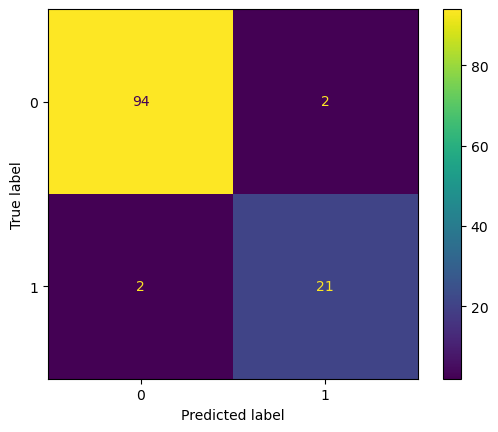

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
print(classification_report(y_test, y_pred))

#### Pruning the decision tree
- Clearly the model is overfitting and tree size is too large
- Need to optimize the tree based off results of the confusion matrix

##### Potential Stategies
- Need to find the right value for the pruning parameter `alpha` which controls how little or how much pruning takes place. 
- One way to find optimal alpha is to plot accuracy of the tree as a function of different values -> this is known as **cost complexity pruning**
- Also need to utilize **cross validation** to ensure that alpha value isn't sensitive to a particular dataset.

<Axes: xlabel='alpha'>

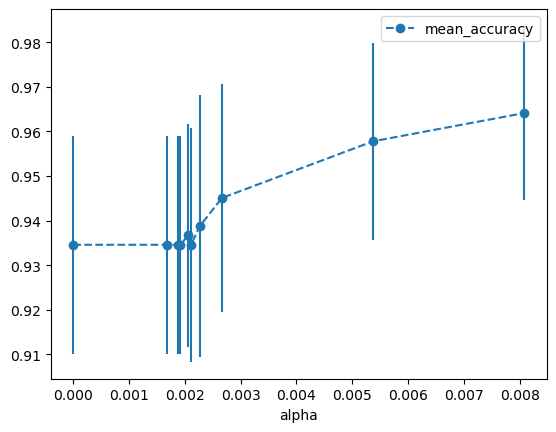

In [11]:
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
ccp_alphas = ccp_alphas[:-1] # exclude maximum value for alpha because it is a trivial case

# array to store results of each fold during cross validation
alpha_loop_values = []

# For each candidate for alpha, run a 5-fold cross validation and store the mean, std, and accuracy in alpha_loop_variables
for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    scores = cross_val_score(clf_dt, X_train, y_train, cv=5)
    alpha_loop_values.append([ccp_alpha, np.mean(scores), np.std(scores)])

# graph means and std of scores for each alpha value
alpha_results = pd.DataFrame(alpha_loop_values, columns=['alpha', 'mean_accuracy', 'std'])

alpha_results.plot(x='alpha',
                   y='mean_accuracy',
                   yerr='std',
                   marker='o',
                   linestyle='--')

In [12]:
ideal_ccp_alpha = alpha_results[
    (alpha_results['alpha'] > 0.001) & (alpha_results['alpha'] < 0.005)
].sort_values('mean_accuracy', ascending=False).iloc[0]['alpha']

ideal_ccp_alpha

0.0026652214511823256

#### Build, Evaluate, and Draw Final Classification Tree

              precision    recall  f1-score   support

           0       0.95      1.00      0.97        96
           1       1.00      0.78      0.88        23

    accuracy                           0.96       119
   macro avg       0.98      0.89      0.93       119
weighted avg       0.96      0.96      0.96       119



[Text(0.6666666666666666, 0.875, 'how_disability_affects_ability_to_work <= 0.0\ngini = 0.294\nsamples = 474\nvalue = [389, 85]\nclass = Unemployed'),
 Text(0.5, 0.625, 'barrier_need_for_special_features <= 0.0\ngini = 0.08\nsamples = 406\nvalue = [389, 17]\nclass = Unemployed'),
 Text(0.3333333333333333, 0.375, 'demographics_age <= 68.5\ngini = 0.261\nsamples = 110\nvalue = [93, 17]\nclass = Unemployed'),
 Text(0.16666666666666666, 0.125, 'gini = 0.367\nsamples = 66\nvalue = [50, 16]\nclass = Unemployed'),
 Text(0.5, 0.125, 'gini = 0.044\nsamples = 44\nvalue = [43, 1]\nclass = Unemployed'),
 Text(0.6666666666666666, 0.375, 'gini = 0.0\nsamples = 296\nvalue = [296, 0]\nclass = Unemployed'),
 Text(0.8333333333333334, 0.625, 'gini = 0.0\nsamples = 68\nvalue = [0, 68]\nclass = Employed')]

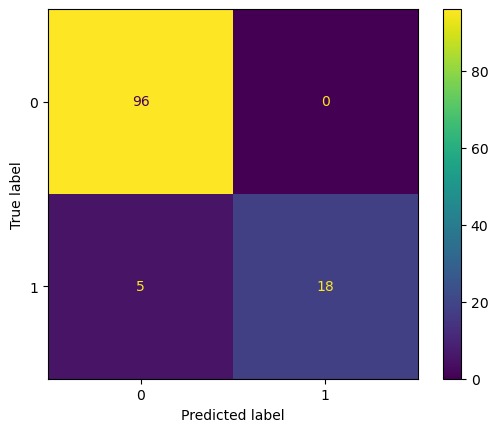

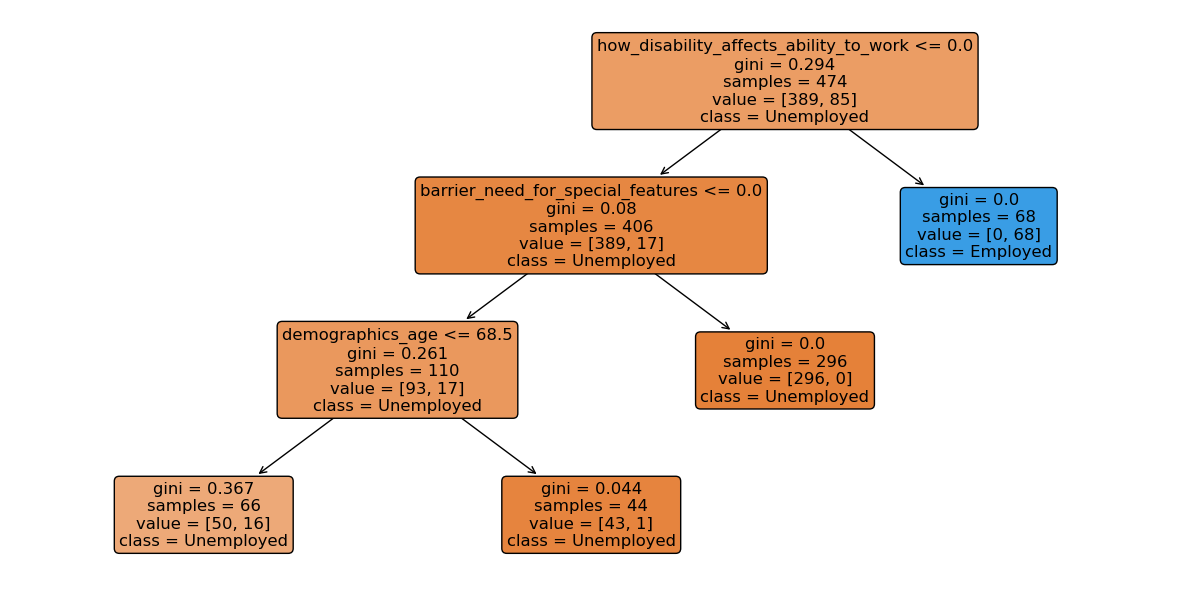

In [13]:
clf_dt_pruned = DecisionTreeClassifier(random_state=42,
                                       ccp_alpha=ideal_ccp_alpha)
clf_dt_pruned = clf_dt_pruned.fit(X_train, y_train)

y_pred = clf_dt_pruned.predict(X_test)
new_cm = confusion_matrix(y_test, y_pred, labels=clf_dt_pruned.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=new_cm, display_labels=clf_dt_pruned.classes_)
disp.plot()
print(classification_report(y_test, y_pred))

# Plot the pruned tree
plt.figure(figsize=(15, 7.5))
plot_tree(clf_dt_pruned,
          filled=True,
          rounded=True,
          class_names=["Unemployed", "Employed"],
          feature_names=x_var.columns,
        )

#### Random Forrest
[https://scikit-learn.org/1.5/modules/generated/sklearn.ensemble.RandomForestClassifier.html] (docs)


c:\anaconda\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


              precision    recall  f1-score   support

           0       0.72      0.67      0.69       415
           1       0.77      0.81      0.79       569

    accuracy                           0.75       984
   macro avg       0.75      0.74      0.74       984
weighted avg       0.75      0.75      0.75       984



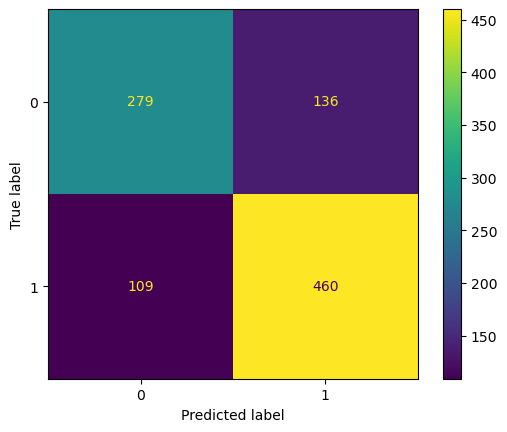

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

data = pd.read_csv('cleaned-data.csv',header=0)
data = data.loc[:,  ~data.columns.str.contains('^Unnamed')]

# 80% training, 20% validation
x_var = data.loc[:, data.columns != "labor_force_employment_status"]
y_var = data.loc[:, data.columns == "labor_force_employment_status"]

X_train, X_test, y_train, y_test = train_test_split(
    x_var,
    y_var,
    test_size=0.2,
    random_state=42
)

# With no hyperparameters
clf_rf = RandomForestClassifier()
clf_rf.fit(X_train, y_train)

y_pred = clf_rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=clf_rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_rf.classes_)
disp.plot()
print(classification_report(y_test, y_pred))


c:\anaconda\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


              precision    recall  f1-score   support

           0       0.81      0.61      0.70       415
           1       0.76      0.90      0.82       569

    accuracy                           0.78       984
   macro avg       0.79      0.75      0.76       984
weighted avg       0.78      0.78      0.77       984



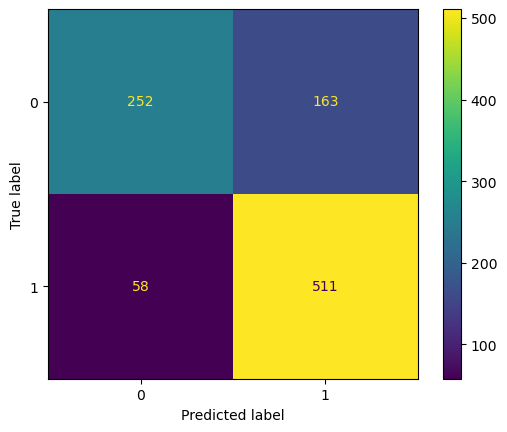

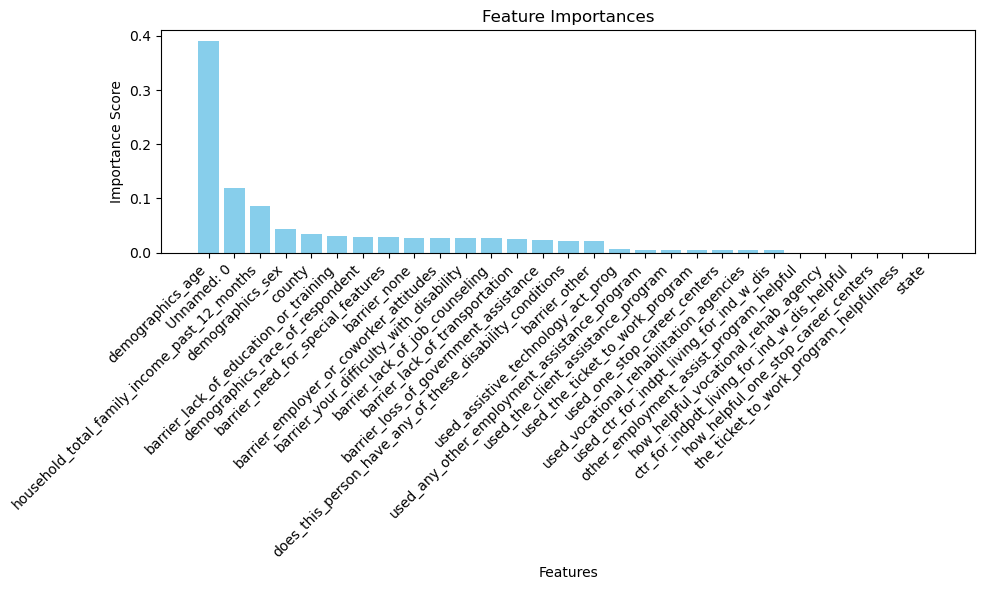

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# adding hyper parameters
clf_rf2 = RandomForestClassifier(n_estimators=1000,
                             criterion='entropy',
                             min_samples_split=10,
                             max_depth=14,
                             random_state=42)
clf_rf2.fit(X_train, y_train)

y_pred = clf_rf2.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=clf_rf2.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_rf2.classes_)
disp.plot()
print(classification_report(y_test, y_pred))

feature_importances = clf_rf2.feature_importances_
feature_names = list(X_train.columns)

# Sort features by importance
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_importances = feature_importances[sorted_indices]
sorted_features = [feature_names[i] for i in sorted_indices]

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(sorted_features, sorted_importances, color='skyblue')
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.title("Feature Importances")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### Neural Network Classifier

Epoch 1
Epoch 101
Epoch 201
Epoch 301
Epoch 401
Epoch 501
Epoch 601
Epoch 701
Epoch 801
Epoch 901
Epoch 1001
Epoch 1101
Epoch 1201
Epoch 1301
Epoch 1401
Epoch 1501
Epoch 1601
Epoch 1701
Epoch 1801
Epoch 1901
Epoch 2001
Epoch 2101
Epoch 2201
Epoch 2301
Epoch 2401
Epoch 2501
Epoch 2601
Epoch 2701
Epoch 2801
Epoch 2901
Epoch 3001
Epoch 3101
Epoch 3201
Epoch 3301
Epoch 3401
Epoch 3501
Epoch 3601
Epoch 3701
Epoch 3801
Epoch 3901
Epoch 4001
Epoch 4101
Epoch 4201
Epoch 4301
Epoch 4401
Epoch 4501
Epoch 4601
Epoch 4701
Epoch 4801
Epoch 4901
              precision    recall  f1-score   support

           0       0.72      0.67      0.69       415
           1       0.77      0.80      0.79       569

    accuracy                           0.75       984
   macro avg       0.74      0.74      0.74       984
weighted avg       0.75      0.75      0.75       984



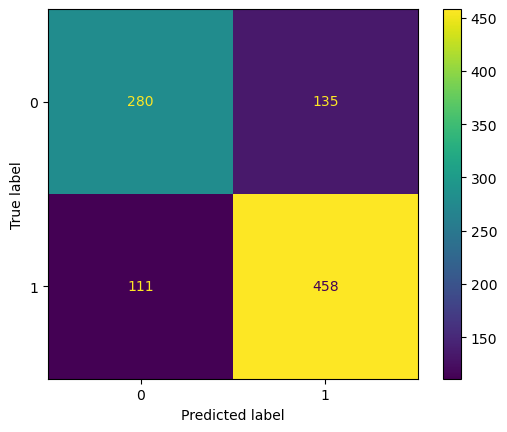

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

data = pd.read_csv('cleaned-data.csv',header=0)
data = data.loc[:,  ~data.columns.str.contains('^Unnamed')]

# 80% training, 20% validation
x_var = data.loc[:, data.columns != "labor_force_employment_status"]
y_var = data.loc[:, data.columns == "labor_force_employment_status"]

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_var)
y_var = y_var.values.ravel()

X_train, X_test, y_train, y_test = train_test_split(
    x_scaled,
    y_var,
    test_size=0.2,
    random_state=42
)

input_features = X_train.shape[1]

class Net(nn.Module):

    def __init__(self, input_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 270)
        self.fc2 = nn.Linear(270, 2)

    def forward(self, x):
        x = self.fc1(x)
        x = F.dropout(x, p=0.1)
        x = F.relu(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)

        return x

net = Net(input_features)

"""
Training Parameters
- Batch size is 50 to avoid overfitting, Training for 50 epochs with learning rate of 0.01
- Use Cross entropy loss function to calculate error during training (commonly used for binary classification)
- Use Adam optimizer to find gradients
"""

# Model params:
batch_size = 50
num_epochs = 1000
learning_rate = 0.01
batch_no = len(X_train) // batch_size

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)


# Iterate for the number of epochs
for epoch in range(num_epochs):
    # Print the epoch number every 5 epochs
    if epoch % 50 == 0:
        print('Epoch {}'.format(epoch+1))

    # Shufle the datasets to randomize the data rows that
    # will be added to the batch and avoid training over the same 50 rows
    # at each epoch
    X_train, y_train = shuffle(X_train, y_train)
    # Mini batch learning
    for i in range(batch_no):
        start = i * batch_size
        end = start + batch_size

        # Convert to PyTorch tensors
        x_var = torch.FloatTensor(X_train[start:end])
        y_var = torch.LongTensor(y_train[start:end])

        # Restart the gradients
        optimizer.zero_grad()

        # Run a training step: Pass the training data to
        # the neural network layers
        ypred_var = net(x_var)

        # Calculate the training loss
        loss =criterion(ypred_var, y_var)

        # update the gradients based on the training loss for the batch
        loss.backward()
        optimizer.step()

# Validation
validation_data = torch.FloatTensor(X_test)
validation_labels = torch.LongTensor(y_test)

# Predict on test data
net.eval()  # Set the model to evaluation mode
with torch.no_grad():
    result = net(validation_data)
    
    # Compute predictions
    _, predicted = torch.max(result, 1)
    predicted_numpy = predicted.numpy()


print(classification_report(y_test, predicted_numpy))
cm = confusion_matrix(y_test, predicted_numpy)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()